In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TODO

1.   add one hot encoding
2.   add privacy accounting
3.   should I rewrote DPSGD or not?
4.   Add gradient store for each step
5.   make sure to store the B in store gradient session.




# Add Library

In [ ]:
!pip install datasets[vision]
!pip install einops
!pip install jaxopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
import argparse
import os
import operator

import datasets
import einops
import numpy as np
import optax
import jax
import jax.numpy as jnp
from flax import serialization
from tqdm import trange

import jaxopt
import matplotlib.pyplot as plt




## params model define

## Add dataset basically we are using MNIST

In [ ]:

def load_dataset():
    """Load and preprocess the MNIST dataset"""
    ds = datasets.load_dataset('mnist')
    ds = ds.map(
        lambda e: {
            'X': einops.rearrange(np.array(e['image'], dtype=np.float32) / 255, "h (w c) -> h w c", c=1),
            'Y': e['label']
        },
        remove_columns=['image', 'label']
    )
    features = ds['train'].features
    features['X'] = datasets.Array3D(shape=(28, 28, 1), dtype='float32')
    ds['train'] = ds['train'].cast(features)
    ds['test'] = ds['test'].cast(features)
    ds.set_format('numpy')
    return ds





## Create the model with flax

In [ ]:
#Some flax defined machine learning models.

from typing import Any

import einops
import flax.linen as nn

ModuleDef = Any

class Softmax(nn.Module):
    @nn.compact
    def __call__(self, x, representation=False):
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        if representation:
            return x
        x = nn.Dense(10, name="classifier")(x)
        return nn.softmax(x)


class LeNet_300_100(nn.Module):
    @nn.compact
    def __call__(self, x, representation=False):
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        x = nn.Dense(300)(x)
        x = nn.relu(x)
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        if representation:
            return x
        x = nn.Dense(10, name="classifier")(x)
        return nn.softmax(x)


class LeNet(nn.Module):
    @nn.compact
    def __call__(self, x, representation=False):
        x = nn.Conv(12, (5, 5), strides=2)(x)
        x = nn.relu(x)
        x = nn.Conv(12, (5, 5), strides=2)(x)
        x = nn.relu(x)
        x = nn.Conv(12, (5, 5), strides=1)(x)
        x = nn.relu(x)
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        if representation:
            return x
        x = nn.Dense(10, name="classifier")(x)
        return nn.softmax(x)


class CNN(nn.Module):
    @nn.compact
    def __call__(self, x, representation=False):
        x = nn.Conv(32, (3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2))
        x = nn.Conv(64, (3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2))
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        if representation:
            return x
        x = nn.Dense(10, name="classifier")(x)
        return nn.softmax(x)

## Add accuracy

In [ ]:
def accuracy(model, params, X, Y, batch_size=1000):
    """Accuracy metric using batch size to prevent OOM errors"""
    acc = 0
    ds_size = len(Y)
    for i in (pbar := trange(0, ds_size, batch_size)):
        end = min(i + batch_size, ds_size)
        acc += jnp.mean(jnp.argmax(model.apply(params, X[i:end]), axis=-1) == Y[i:end])
        pbar.set_postfix_str(f"Running Acc: {acc / jnp.ceil((i + 1) / batch_size):.3%}")
    return acc / jnp.ceil(ds_size / batch_size)


# Define loss with cross entropy

In [ ]:
def celoss_int_labels(model):
    """Cross entropy loss with some clipping to prevent NaNs"""
    @jax.jit
    def _apply(params, X, Y):
        logits = jnp.clip(model.apply(params, X), 1e-15, 1 - 1e-15)
        one_hot = jax.nn.one_hot(Y, logits.shape[-1])
        return -jnp.mean(jnp.einsum("bl,bl -> b", one_hot, jnp.log(logits)))
    return _apply


def celoss(model):
    """Cross entropy loss with some clipping to prevent NaNs"""
    @jax.jit
    def _apply(params, X, Y):
        logits = jnp.clip(model.apply(params, X), 1e-15, 1 - 1e-15)
        return -jnp.mean(jnp.einsum("bl,bl -> b", Y, jnp.log(logits)))
    return _apply

#Add gradient function

##Add DP gradient update with norm of params

In [ ]:
#ez version of dpsgd
def dp_value_and_grad(loss, l2_norm_clip, sigma, rng=np.random.default_rng()):
    def _apply(params, X, Y):
        loss_val, grads = jax.value_and_grad(loss)(params, X, Y)
        norm = jnp.linalg.norm(jax.flatten_util.ravel_pytree(params)[0])
        grads = jax.tree_util.tree_map(lambda x: x / jnp.maximum(norm / l2_norm_clip, 1), grads)
        grads = jax.tree_util.tree_map(lambda x: x + rng.normal(0, l2_norm_clip**2 * sigma**2, x.shape), grads)
        return loss_val, grads
    return _apply

In [ ]:
class FLAGS:
    dpsgd = True
    learning_rate = 0.1
    noise_multiplier = 1.1
    l2_norm_clip = 1.0
    batch_size = 2
    epochs = 10
    model_dir = f"/content/drive/MyDrive/Jax_gradient/SoftmaxDP.params"
    gradient_dir = f"/content/drive/MyDrive/Jax_gradient/SoftmaxDP.grads"
    model=Softmax()
    train_step_num=3000
    selected_attack_index=0
    loss_function=celoss_int_labels(model)
    #loss_function="celoss_onehot"
    optimizer=optax.sgd(learning_rate)

##Add DPSGD gradient update with clips as well as adding noise

In [ ]:

#DP SGD version
def clipped_grad(grads, l2_norm_clip):
    """Evaluate gradient for a single-example batch and clip its grad norm."""

    nonempty_grads, tree_def = jax.tree_flatten(grads)
    total_grad_norm = jnp.linalg.norm(
        jnp.asarray([jnp.linalg.norm(neg.ravel()) for neg in nonempty_grads]))
    divisor = jnp.maximum(total_grad_norm / l2_norm_clip, 1.)
    normalized_nonempty_grads = [g / divisor for g in nonempty_grads]
    return jax.tree_unflatten(tree_def, normalized_nonempty_grads)

def private_grad(params, batch, rng, l2_norm_clip, noise_multiplier,
                 batch_size):
  #take smae model/parameters same batch,clip gradient: should as close possible to same batch-true dataset == same match
  # dataset remember infomation history gradient dataset on noisy gradient. data distrallation. which batch-gradient similar?
  # XX everythong noisey
  #
    """Return differentially private gradients for params, evaluated on batch."""

    loss_val, clipped_grads = jax.vmap(clipped_grad, (None, None, 0))(params,  X, Y)
    clipped_grads_flat, grads_treedef = jax.tree_flatten(clipped_grads)
    aggregated_clipped_grads = [g.sum(0) for g in clipped_grads_flat]
    rngs = jax.random.split(rng, len(aggregated_clipped_grads))
    noised_aggregated_clipped_grads = [
        g + l2_norm_clip * noise_multiplier * jax.random.normal(r, g.shape)
        for r, g in zip(rngs, aggregated_clipped_grads)]
    normalized_noised_aggregated_clipped_grads = [
        g / batch_size for g in noised_aggregated_clipped_grads]


    return loss_val,jax.tree_unflatten(grads_treedef, normalized_noised_aggregated_clipped_grads)

##Add easier version of DPSGD for debugging

In [ ]:
def private_grad_ez(clipped_grads,rng, l2_norm_clip, noise_multiplier,
                 batch_size):
  #take smae model/parameters same batch,clip gradient: should as close possible to same batch-true dataset == same match
  # dataset remember infomation history gradient dataset on noisy gradient. data distrallation. which batch-gradient similar?
  # XX everythong noisey
  #
    """Return differentially private gradients for params, evaluated on batch."""


    clipped_grads_flat, grads_treedef = jax.tree_flatten(clipped_grads)
    aggregated_clipped_grads = [g.sum(0) for g in clipped_grads_flat]
    rngs = jax.random.split(rng, len(aggregated_clipped_grads))
    noised_aggregated_clipped_grads = [
        g + l2_norm_clip * noise_multiplier * jax.random.normal(r, g.shape)
        for r, g in zip(rngs, aggregated_clipped_grads)]
    normalized_noised_aggregated_clipped_grads = [
        g / batch_size for g in noised_aggregated_clipped_grads]


    return jax.tree_unflatten(grads_treedef, normalized_noised_aggregated_clipped_grads)

Add training steps

In [ ]:
def train_step(opt, value_and_grad):
    """The training function using optax, also returns the training loss"""
    @jax.jit
    def _apply(params, opt_state, X, Y):
        loss_val, grads = value_and_grad(params, X, Y)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val,grads
    return _apply

In [ ]:
def robust_train_step(opt, loss, value_and_grad, epsilon=0.3, lr=0.001, steps=40):
    """AT training step proposed in https://arxiv.org/pdf/1706.06083.pdf"""
    @jax.jit
    def _apply(params, opt_state, X, Y):
        X_nat = X
        for _ in range(steps):
            grads = jax.grad(loss, argnums=1)(params, X, Y)
            X = X + lr * jnp.sign(grads)
            X = jnp.clip(X, X_nat - epsilon, X_nat + epsilon)
            X = jnp.clip(X, 0, 1)
        loss_val, grads = value_and_grad(params, X, Y)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val
    return _apply



Create Models

#dataset loading

In [ ]:

ds = load_dataset()

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/60000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
ds = load_dataset()
X, Y = ds['train']['X'], ds['train']['Y']
key = jax.random.PRNGKey(42)
key, pkey = jax.random.split(key)

# # initialize the weights
model=FLAGS.model
params = model.init(pkey, X[:1])
opt = FLAGS.optimizer
opt_state = opt.init(params)
loss = FLAGS.loss_function


v_and_g = dp_value_and_grad(loss, 0.1,  0.1)

trainer = train_step(opt, v_and_g)
rng = np.random.default_rng()
train_len = len(Y)
train_step_num=FLAGS.train_step_num
fn = FLAGS.model_dir
gradient_dir=FLAGS.gradient_dir
grad_steps=1
batch_size=1


In [ ]:
X[:1].shape

(1, 28, 28, 1)

In [ ]:
params['params']


{'classifier': {'kernel': Array([[ 0.01016189,  0.03502801,  0.04478025, ...,  0.05589119,
          -0.02706997, -0.02783698],
         [-0.01217686, -0.04114753,  0.00813893, ...,  0.0087596 ,
           0.01024607,  0.02724785],
         [-0.03148305,  0.06369679,  0.0232012 , ...,  0.07404393,
           0.04443935, -0.01648801],
         ...,
         [ 0.02751287,  0.05593653, -0.00653277, ..., -0.01995059,
          -0.01939776, -0.03162035],
         [-0.00181705,  0.01364394,  0.05458512, ..., -0.03259211,
          -0.02058766,  0.04010798],
         [-0.06342019,  0.00167369,  0.01007248, ...,  0.07769884,
           0.0329999 ,  0.029055  ]], dtype=float32),
  'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}}

In [ ]:
for _ in (pbar := trange(train_step_num)):
    idx = rng.choice(train_len, 32, replace=False)
    params, opt_state, loss_val,tempgrads = trainer(params, opt_state, X[idx], Y[idx])
    pbar.set_postfix_str(f"LOSS: {loss_val:.5f}")
print(f"Final accuracy: {accuracy(model, params, ds['test']['X'], ds['test']['Y']):.3%}")
os.makedirs('data', exist_ok=True)
with open(fn, 'wb') as f:
    f.write(serialization.to_bytes(params))
print(f'Saved final model to {fn}')


100%|██████████| 10/10 [00:03<00:00,  2.99it/s, Running Acc: 85.400%]


Final accuracy: 85.400%
Saved final model to /content/drive/MyDrive/Jax_gradient/SoftmaxDP.params


In [ ]:
    # Generate the gradients to be attacked
new_params = params
idx=FLAGS.selected_attack_index
for _ in (pbar := trange(grad_steps)):
  #idx = rng.choice(train_len,batch_size, replace=False)
  new_params, opt_state, loss_val,tempgrads = trainer(new_params, opt_state, X[[idx]], Y[[idx]])
grads = jax.tree_util.tree_map(operator.sub, params, new_params)
fn = gradient_dir
with open(fn, 'wb') as f:
  f.write(serialization.to_bytes(grads))
print(f'Saved final gradient to {fn}')

100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Saved final gradient to /content/drive/MyDrive/Jax_gradient/SoftmaxDP.grads


In [ ]:
grads

{'params': {'classifier': {'bias': Array([ 7.0404261e-05,  2.2113323e-05,  3.4878030e-05,  8.2681701e-04,
           6.2733889e-06, -1.2420863e-03,  6.3955784e-05,  6.1254948e-05,
           9.2707574e-05,  6.7345798e-05], dtype=float32),
   'kernel': Array([[ 1.0784250e-05, -9.1306865e-06,  1.5344471e-05, ...,
            5.0570816e-07,  7.9218298e-06,  5.2051619e-06],
          [-5.7499856e-06,  6.1653554e-06,  6.4284886e-06, ...,
           -1.5410362e-05, -8.0643222e-06,  2.2895634e-05],
          [ 7.8566372e-06,  6.4969063e-06, -5.0961971e-06, ...,
           -2.1457672e-05, -9.7975135e-07,  2.4247915e-05],
          ...,
          [-1.7199665e-05, -4.1872263e-06,  3.0398369e-06, ...,
            2.1625310e-06,  1.2788922e-05,  3.1627715e-06],
          [-7.8976154e-06, -6.5509230e-06, -8.0615282e-06, ...,
           -1.7248094e-06, -1.9453466e-05,  9.2778355e-06],
          [-2.1643937e-06, -5.7742000e-08,  1.1123717e-05, ...,
            4.3883920e-06, -3.8333237e-06,  8.493661

In [ ]:
labels = jnp.argsort(
        jnp.min(grads['params']['classifier']['kernel'], axis=0)
    )[:1]
true_reps2 = np.asarray(grads['params']['classifier']['kernel']).T[[7 ]]

In [ ]:
np.asarray(grads['params']['classifier']['kernel']).shape

(784, 10)

In [ ]:
labels.tolist()

[5]

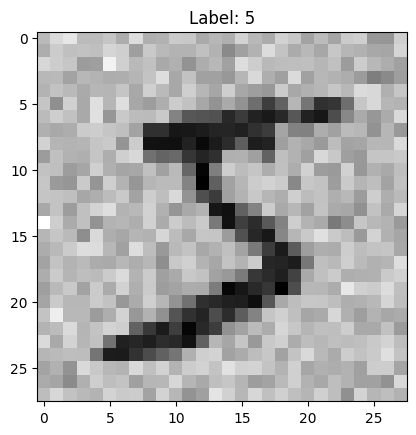

In [ ]:
plt.title(f"Label: {Y[0]}")
plt.imshow(true_reps2[0].reshape(28,28,1), cmap="binary")

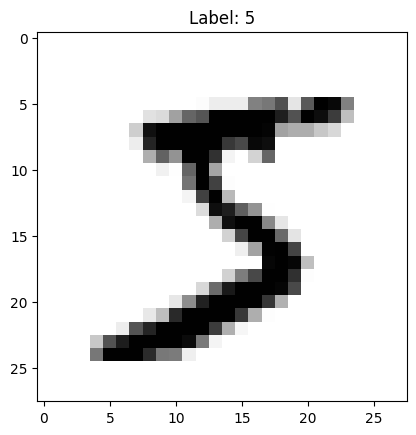

In [ ]:
plt.title(f"Label: {Y[0]}")
plt.imshow(X[[idx]].reshape(28,28,1), cmap="binary")

inference testing

# Attack Function

In [ ]:
def load_model():
    """
    Load the model, parameters and the true gradients,
    """
    model = Softmax()
    params = model.init(jax.random.PRNGKey(0), jnp.zeros((32, 28, 28, 1)))
    fn = "/content/drive/MyDrive/Jax_gradient/SoftmaxDP.params"
    with open(fn, 'rb') as f:
        params = serialization.from_bytes(params, f.read())
    fn = "/content/drive/MyDrive/Jax_gradient/SoftmaxDP.grads"
    with open(fn, 'rb') as f:
        true_grads = serialization.from_bytes(params, f.read())
    return model, params, true_grads


In [ ]:
def dlg_loss(loss, params, true_grads):
    """Finds the euclidean distance beween the gradient from dummy data and the true gradient"""
    @jax.jit
    def _apply(X, Y):
        norm_tree = jax.tree_map(lambda a, b: jnp.sum((a - b)**2), jax.grad(loss)(params, X, Y), true_grads)
        return jax.tree_util.tree_reduce(operator.add, norm_tree)
    return _apply

In [ ]:
# Representation inversion attack proposed in https://arxiv.org/abs/2202.10546
def cosine_dist(A, B):
    denom = jnp.maximum(jnp.linalg.norm(A, axis=1) * jnp.linalg.norm(B, axis=1), 1e-15)
    return 1 - jnp.mean(jnp.abs(jnp.einsum('br,br -> b', A, B)) / denom)

In [ ]:
def total_variation(V):
    return abs(V[:, 1:, :] - V[:, :-1, :]).sum() + abs(V[:, :, 1:] - V[:, :, :-1]).sum()


In [ ]:
def atloss(model, params, true_reps, lamb_tv=1e-3):
    def _apply(Z):
        dist = cosine_dist(model.apply(params, Z, representation=True), true_reps)
        return dist + lamb_tv * total_variation(Z)
    return _apply

# Begin Attack

In [ ]:
model, params, true_grads = load_model()

In [ ]:
labels = jnp.argsort(
        jnp.min(tempgrads['params']['classifier']['kernel'], axis=0)
    )[:1]
true_reps = np.asarray(tempgrads['params']['classifier']['kernel']).T[labels.tolist()]


In [ ]:
true_reps[0].reshape(28,28,1)

array([[[-7.18816591e-05],
        [-1.78281756e-04],
        [ 8.25805255e-05],
        [-9.36970901e-05],
        [ 1.02912563e-04],
        [-6.12831063e-05],
        [-1.10672096e-04],
        [-5.69138319e-05],
        [-9.38483572e-05],
        [-6.36498953e-05],
        [-1.77044858e-04],
        [ 2.50241942e-06],
        [-3.80603669e-05],
        [ 4.03000595e-05],
        [-2.86223303e-06],
        [-1.04913779e-04],
        [ 1.18923301e-04],
        [-4.10006351e-06],
        [ 7.26076905e-05],
        [ 4.96559824e-06],
        [ 5.56586656e-06],
        [ 3.70537709e-05],
        [ 1.53368033e-04],
        [ 7.91519851e-05],
        [-1.27821377e-05],
        [ 1.20535833e-05],
        [-8.42682348e-05],
        [-7.64235956e-05]],

       [[ 3.29472496e-05],
        [-1.58770912e-04],
        [ 1.60721815e-04],
        [-3.01430482e-05],
        [-6.76203344e-05],
        [ 2.88905430e-05],
        [-6.75943593e-05],
        [-1.14522467e-04],
        [-1.12997754e-04],

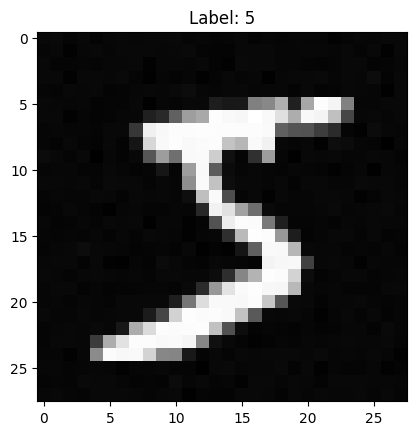

In [ ]:
plt.title(f"Label: {Y[0]}")
plt.imshow(true_reps[0].reshape(28,28,1), cmap="binary")

In [ ]:
templist=np.asarray(tempgrads['params']['classifier']['kernel'])

In [ ]:
templist.T[5].shape

(784,)

In [ ]:
np.asarray(tempgrads['params']['classifier']['kernel']).T[labels.tolist()].shape

(1, 784)

In [ ]:
jnp.argsort(
        jnp.min(tempgrads['params']['classifier']['kernel'], axis=0)
    )

Array([5, 8, 7, 0, 4, 9, 2, 3, 1, 6], dtype=int32)

In [ ]:
rngkey = jax.random.PRNGKey(42)
xkey, ykey = jax.random.split(rngkey)
Z = jax.random.normal(xkey, (1, 28, 28, 1))


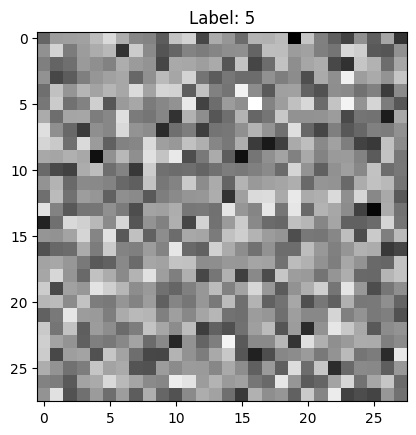

In [ ]:
plt.title(f"Label: {Y[0]}")
plt.imshow(Z[0], cmap="binary")

## DLG

In [ ]:
loss_fn = lambda X: dlg_loss(celoss(model), params, tempgrads)(X, jax.nn.one_hot(labels, 10))
pre_update = lambda X, s: (jnp.clip(X, 0., 1.), s)
opt = optax.sgd(0.01)



## AT

In [ ]:
loss_fn = atloss(model, params, true_reps)
opt = optax.adam(0.01)
pre_update = lambda X, s: (jnp.clip(X, 0., 1.), s)

In [ ]:
solver = jaxopt.OptaxSolver(loss_fn, opt, pre_update=pre_update)
state = solver.init_state(Z)
trainer = jax.jit(solver.update)

##perform attack

In [ ]:
for _ in (pbar := trange(3000)):
        Z, state = trainer(Z, state)
        pbar.set_postfix_str(f"LOSS: {state.value:.5f}")

100%|██████████| 3000/3000 [00:07<00:00, 412.47it/s, LOSS: 0.00221]


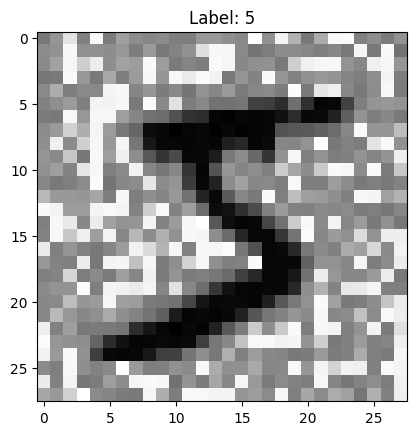

In [ ]:
plt.title(f"Label: {labels[0]}")
plt.imshow(Z[0], cmap="binary")